In [1]:
import numpy as np
from matplotlib import pyplot as plt
from IPython import display

In [2]:
numActions = list(range(6,98,5))[1]

train_actions = np.load('./data/actions_%02d.npy'%numActions,allow_pickle=True)
train_ims = np.load('./data/word_pics_%02d.npy'%numActions)

In [3]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from model import Sampler, SinkhornNet
device = torch.device('cuda:0')

In [4]:
# act_idxs = np.ones((len(train_actions),numActions))*0
# seq_len = []
# for j,act_idx in enumerate(train_actions):
#     seq_len.append(act_idx.shape[0]-1)
#     act_idxs[j,0:act_idx.shape[0]] = act_idx
K = 6
a_one_hot = np.zeros((train_actions.shape[0],numActions,numActions))
seq_len = []
for i,a in enumerate(train_actions):
    seq_len.append(a.shape[0]-1)
    oh = np.zeros((numActions,numActions))
    oh[np.arange(a.shape[0]),a] = 1
    a_one_hot[i,:,:] = oh

In [5]:
dataset = Sampler(np.swapaxes(np.stack(train_ims),1,3),a_one_hot,np.array(seq_len),numActions)
train_dataset,test_dataset = torch.utils.data.random_split(dataset,[10000,5000])

In [6]:
batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

In [7]:
sn = SinkhornNet(latent_dim=2048, image_channels=3, max_K=6, n_samples=5, noise_factor=1.0, temp=1.5, n_iters=20, K=numActions)
sn.to(device)
optimizer = torch.optim.Adam(sn.parameters(), lr=3e-4)
n_epochs = 500
losses = []
losses_m = []

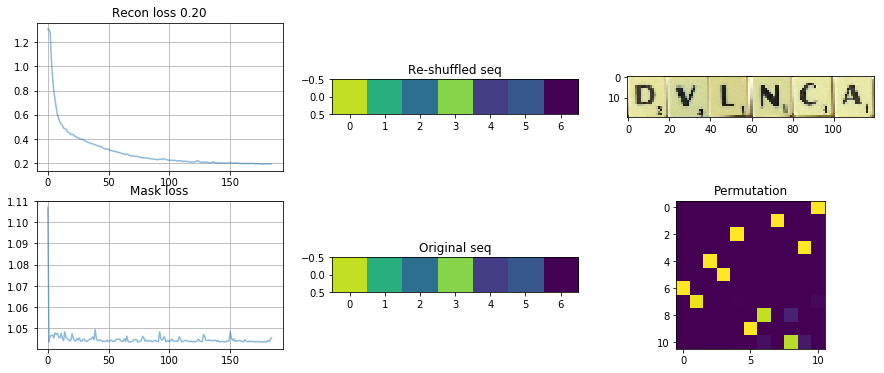

KeyboardInterrupt: 

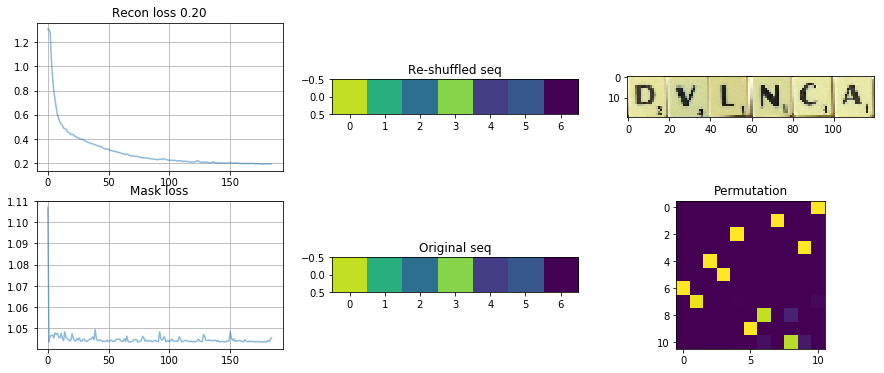

In [8]:
plt.figure(figsize=(15,6))

for j in range(n_epochs):
    
    batch_losses = []
    batch_losses_m = []
    for im, seq, seq_order,seq_len in train_loader:
    
        loss_r,loss_m, seq_pred,mask = sn.loss(seq, im, seq_order,seq_len)
        
        batch_losses.append(loss_r.item())
        batch_losses_m.append(loss_m.item())
        
        loss = loss_r + loss_m
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        
    losses.append(np.mean(batch_losses))
    losses_m.append(np.mean(batch_losses_m))
    
    plt.clf()
    plt.cla()
    plt.subplot(2,3,1)
    plt.plot(losses,alpha=0.5)
    plt.title('Recon loss %4.2f'%losses[-1])
    plt.grid()
    plt.subplot(2,3,4)
    plt.plot(losses_m,alpha=0.5)
    plt.title('Mask loss')
    plt.grid()

    plt.subplot(2,3,6)
    P = sn.predict_P(im)
    plt.imshow(P[0,:,:].cpu().detach().numpy())
    plt.title('Permutation')
    
    plt.subplot(2,3,2)
    plt.imshow(np.argmax(seq_pred[0,0:7,:].cpu().detach().numpy(),-1).reshape(1,-1),vmin=0,vmax=numActions)
    plt.title('Re-shuffled seq')
    
    
    plt.subplot(2,3,5)
    plt.imshow(np.argmax(seq[0,0:7,:].cpu().detach().numpy(),-1).reshape(1,-1),vmin=0,vmax=numActions)
    plt.title('Original seq')
    
    plt.subplot(2,3,3)
    plt.imshow(np.swapaxes(im[0,:,:,:].cpu().detach().numpy()+0.5,0,2))
    
    display.clear_output(wait=True)
    display.display(plt.gcf())
    

In [9]:
# Evaluate model
sn.eval()
sn.noise_factor = 0.0
sn.n_samples = 1

In [13]:
from scipy.stats import kendalltau
tau_list = []
Acc = []
Precision = []
for im,seq,seq_ordered,seq_len in test_loader:
    P = sn.predict_P(im)
    order,stop = sn(seq_ordered,im)
    Acc.append(np.argmax(stop.cpu().detach().numpy(),1)==(seq_len.cpu().numpy()))
    obj_ids = np.argmax(P[0,:,:].cpu().detach().numpy(),1)
    tau, _ = kendalltau(obj_ids[0:(seq_len.cpu().numpy()[0]+1)], np.argmax(seq[0,0:(seq_len.cpu().numpy()[0]+1),:].cpu().numpy(),1))
    tau_list.append(tau)
    
    Precision.append(np.sum((obj_ids[0:(seq_len.cpu().numpy()[0]+1)]==np.argmax(seq[0,0:(seq_len.cpu().numpy()[0]+1),:].cpu().numpy(),1)))/(seq_len.cpu().numpy()[0]+1))


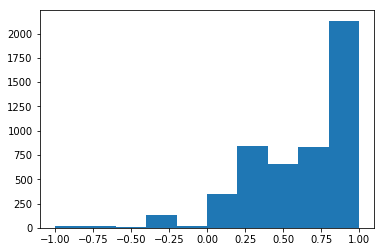

In [14]:
plt.hist(np.array(tau_list))
plt.show()

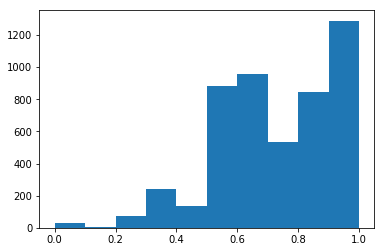

In [15]:
plt.hist(Precision)
plt.show()

In [16]:
np.mean(tau_list),np.mean(Precision)

(0.6661341888403313, 0.7299766666666666)

In [ ]:
# torch_test_ims = torch.from_numpy(np.swapaxes(test_ims,1,3)).float().to(device)
# P = sn.predict_P(torch_test_ims)
# order_test = torch.FloatTensor(np.arange(numActions).astype('float')).reshape(1,numActions).repeat(test_ims.shape[0],1).to(device)
# order,stop = sn(order_test,torch_test_ims)
# predicted_actions = np.argmax(P.cpu().detach().numpy(),1)
# stopping_bins = np.argmax(stop.cpu().detach().numpy(),1)

In [ ]:
# import string
# alphabet = list(string.ascii_lowercase)
# #reps = [9,2,2,4,12,2,3,2,9,1,1,4,2,6,8,2,1,6,4,6,4,2,2,1,2,1] - full set
# reps = [2 for j in range(26)]
# actions = []
# for i,r in enumerate(reps):
#     actions = actions + [alphabet[i]]*reps[i]

In [ ]:
# for j in range(5):
#     plt.imshow(test_ims[:,:,:,:].reshape(-1,6*20,3))
#     plt.axis('off')
# plt.subplots_adjust(hspace=0,wspace=0)
# plt.show()

# for i in range(predicted_actions.shape[0]):
#     for k in range(stopping_bins[i]):
#         print(actions[predicted_actions[i,k]],end='')
#     print()
